<a href="https://colab.research.google.com/github/cavitcakir/SkinCancerClassification/blob/master/skin_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Dataframe

We imported all the functions and libraries we might possibly use in this model, but we add on some functions as we need them. We mounted the drive and read the inital, raw dataframe coming from VectorizingData notebook.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import PIL
import gc
import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
from math import ceil
import math
import sys
import gc

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras import applications
from keras.models import Model
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping

from keras.activations import softmax
from keras.activations import elu
from keras.activations import relu
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We used pickle function to not loose any information in image column.

In [0]:
df = pd.read_pickle('/content/drive/My Drive/CS 412 PROJECT/data/data224x224.csv')
#df['image'] = df['image'].map(lambda img: img/255)
df.head()

,Id,Category,path,image
0,Image_1,1,/content/gdrive/My Drive/CS 412 PROJECT/Data_S...,"[[[191, 100, 95], [194, 104, 97], [194, 104, 9..."
1,Image_2,1,/content/gdrive/My Drive/CS 412 PROJECT/Data_S...,"[[[147, 127, 138], [148, 128, 139], [146, 126,..."
2,Image_3,4,/content/gdrive/My Drive/CS 412 PROJECT/Data_S...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,Image_4,1,/content/gdrive/My Drive/CS 412 PROJECT/Data_S...,"[[[9, 4, 10], [6, 3, 8], [5, 3, 8], [7, 6, 11]..."
4,Image_5,0,/content/gdrive/My Drive/CS 412 PROJECT/Data_S...,"[[[216, 189, 153], [216, 187, 149], [216, 184,..."


# Data Understanding & Preparation

We looked at the shape our images because it will be used a lot in the models. We performed the train test split(this is the final version where we don't have any test data like mentioned in the report). After that, we brought our data to the desired shape, we used one-hot encoding for Catgory values and we turned the images into arry type and reshaped it to fit the models.

In [0]:
print(df['image'][0].shape)

(224, 224, 3)


In [0]:
#features and labels are splitted
X = df['image']
y = df['Category']

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
#train-validation split
from keras.utils import np_utils
trainx, valx, trainy, valy = train_test_split(X, y, test_size=0.03,random_state=41)
testx = valx
testy = valy

In [0]:
#turning image vectors into arrays
trainx = np.asarray(trainx.tolist())
testx = np.asarray(testx.tolist())
valx = np.asarray(valx.tolist())

In [0]:
#encoding the categories using one hot encoding
print("Shape before one-hot encoding: ", trainy.shape)
trainy = np_utils.to_categorical(trainy, 5)
testy = np_utils.to_categorical(testy, 5)
valy = np_utils.to_categorical(valy, 5)
print("Shape after one-hot encoding: ", trainy.shape)


Shape before one-hot encoding:  (9700,)
Shape after one-hot encoding:  (9700, 5)


In [0]:
print("X_train shape", trainx.shape)
print("y_train shape", trainy.shape)
print("X_val shape", valx.shape)
print("y_val shape", valy.shape)
print("X_test shape", testx.shape)
print("y_test shape", testy.shape)

X_train shape (9700, 224, 224, 3)
y_train shape (9700, 5)
X_val shape (300, 224, 224, 3)
y_val shape (300, 5)
X_test shape (300, 224, 224, 3)
y_test shape (300, 5)


In [0]:
#reshaping the arrays to fit the models
trainx = trainx.reshape(trainx.shape[0], *(224, 224, 3))
testx = testx.reshape(testx.shape[0], *(224, 224, 3))
valx = valx.reshape(valx.shape[0], *(224, 224, 3))

#  CNN

This is the part where we developed the model, we used CNNs more specifically ImageNet Transfer Learning models. We tried AlexNet, VGG-16, Inception v3-v4, NasNetMobile, MobileNet, ResNet-50. The most successful in our case was ResNet-50 which is used in our main model SahmerdanNet. We fine-tuned the models, we changed image sizes, dropout rates, epoch number, batsch sizes, number of layers that are freezed and added after and a lot of other hyper-parameters. We used callbacks such as ReduceLRonPlateau to avoid overfitting and checkpoints to acquire the very best model possible.

### SahmerdanNet

Data Augmentation were performed in this section. Additionally, preprocessing of data is inside the data augmentation.

In [0]:
from keras.applications.resnet import preprocess_input

#choosing the generator and the differences that would happen in the generated images
train_datagen = ImageDataGenerator(
preprocessing_function=preprocess_input, 
rescale=1./255,
rotation_range=180,
width_shift_range=0.1,
height_shift_range=0.1,
brightness_range=[0.5,1.5],
zoom_range=0.6,
horizontal_flip=True,
vertical_flip=True,
fill_mode='nearest')

#choosing the generator and the differences that would happen in the generated images
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input,
    brightness_range=[0.5,1.5])


#generating additional data
train_generator = train_datagen.flow(
    trainx,
    y=trainy,
    batch_size=32,
    shuffle=True,
    seed=42
    )

#generating additional data
valid_generator=test_datagen.flow(
    valx,
    y=valy,
    batch_size=32,
    shuffle=True,
    seed=42
    )

In [0]:
from keras.applications.resnet50 import ResNet50
input_shape = (224,224,3)
lr = 1e-5
epochs = 30
batch_size = 16

base_model = ResNet50(include_top=False, input_shape= (224,224,3), weights = 'imagenet') #base model

x = base_model.output

x = GlobalAveragePooling2D()(x) #extra layers
x = Dropout(0.35)(x) #to avoid overfitting
predictions = Dense(5, activation= 'softmax')(x) #output dense layer, we used softmax because it is multiclass
model = Model(inputs = base_model.input, outputs = predictions)


model.compile(optimizer = Adam(lr) ,
              loss = "categorical_crossentropy", 
              metrics=["accuracy"]) #this is the comiler we used Adam with a given learning rate

checkpoint = ModelCheckpoint('/content/drive/My Drive/CS 412 PROJECT/cavit notebooks/kralcheckpoint2.h5', monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max') #this is the function that saves the best epoch

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, 
                                   verbose=1, mode='max', min_lr=0.00001) #another overfitting measure
                              
                              
callbacks_list = [checkpoint, reduce_lr]


history = model.fit_generator(train_generator,
 validation_data = valid_generator, steps_per_epoch = 600,
 epochs = epochs,
 callbacks= callbacks_list) #training of the model



/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/30
600/600 [==============================] - 253s 422ms/step - loss: 1.1636 - accuracy: 0.5476 - val_loss: 1.5884 - val_accuracy: 0.2500

Epoch 00001: val_accuracy improved from -inf to 0.25000, saving model to /content/drive/My Drive/CS 412 PROJECT/cavit notebooks/kralcheckpoint2.h5
Epoch 2/30
600/600 [==============================] - 236s 393ms/step - loss: 0.9287 - accuracy: 0.6441 - val_loss: 1.1066 - val_accuracy: 0.7433

Epoch 00002: val_accuracy improved from 0.25000 to 0.74333, saving model to /content/drive/My Drive/CS 412 PROJECT/cavit notebooks/kralcheckpoint2.h5
Epoch 3/30
600/600 [==============================] - 234s 390ms/step - loss: 0.8435 - accuracy: 0.6724 - val_loss: 0.3795 - val_accuracy: 0.7967

Epoch 00003: val_accuracy improved from 0.74333 to 0.79667, saving model to /content/drive/My Drive/CS 412 PROJECT/cavit notebooks/kralcheckpoint2.h5
Epoch 4/30
600/600 [==============================] - 234s 389ms/step - loss: 0.7812 - accuracy: 0.6969 - val_lo

#Evaluation

Evaluation part starts with saving the model if necessary( it is not in this case), preprocessing the test data and generating additional test data.

In this final form of the project we do not use test data because we will have Kaggle perform the final test, but in the previous versions we had a 10% test data.

In [0]:
# # serialize model to JSON
# model_json = model.to_json()
# with open("/content/drive/My Drive/CS 412 PROJECT/cavit notebooks/kral2.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("/content/drive/My Drive/CS 412 PROJECT/cavit notebooks/kral2.h5")
# print("Saved model to disk")

#preprocessing data for the test
final_test = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input,
    brightness_range=[0.5,1.5])

#generating data for the best
# test_generator=final_test.flow(
#     testx,
#     batch_size=32,
#     shuffle=False,
#     seed=42
#     )

We get predictions and accuracy scores for both the last epoch and best epoch (which we saved using checkpoint) to see which one is better.

In [0]:
#evaluating the last epoch

pred = model.predict_generator(test_generator)
a = np.argmax(pred, axis=1)

from sklearn.metrics import accuracy_score
accuracy_last  =  accuracy_score(np.argmax(testy, axis=1), a)
print(accuracy_score(np.argmax(testy, axis=1), a))

0.809


In [0]:
#evaluating the best epoch
#did not performed in the final form

model.load_weights('/content/drive/My Drive/CS 412 PROJECT/cavit notebooks/kral2.h5')
# pred = model.predict_generator(test_generator)
# a = np.argmax(pred, axis=1)

# from sklearn.metrics import accuracy_score
# accuracy_checkpint = accuracy_score(np.argmax(testy, axis=1), a)
# print(accuracy_score(np.argmax(testy, axis=1), a))

We choose the best one and get results.

In [0]:
if accuracy_checkpint < accuracy_last:
  model.load_weights('/content/drive/My Drive/CS 412 PROJECT/cavit notebooks/gener_100_32.h5')

### Get result





We read the test raw data we prepared in VectorizingOutput notebook, we preprocess and prepare the data and perform predictions. Then we get it in the appropriate format and saved it in a csv file with the Image IDs. 

In [0]:
test_df = pd.read_pickle('/content/drive/My Drive/CS 412 PROJECT/testRAW224x224.csv')

In [0]:
testdatax = test_df['image']
testdatax = np.asarray(testdatax.tolist())

#preprocessing data
allahu_akbar=final_test.flow(
    testdatax,
    batch_size=32,
    shuffle=False,
    seed=42
    )

#performing final predictions
predfinal = model.predict_generator(allahu_akbar)
a2 = np.argmax(predfinal, axis=1)

#storing it in a dataframe and saving the dataframe in a .csv file
new_df = pd.DataFrame({'Category': a2+1}) #getting category in the desired form
columns = ['Id','Category']
out_df = pd.DataFrame(columns=columns)
out_df = test_df[['Id']].copy()
artikson = pd.concat([out_df, new_df], axis=1)
artikson['Category'] = artikson['Category'].astype(int)
artikson.to_csv('/content/drive/My Drive/CS 412 PROJECT/kral2.csv',index=False)
print('done bitch')



done bitch


### Graph of the model

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


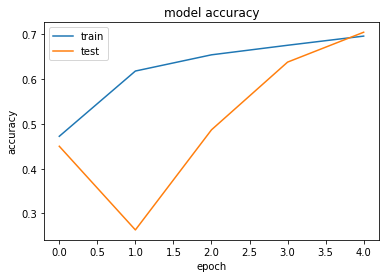

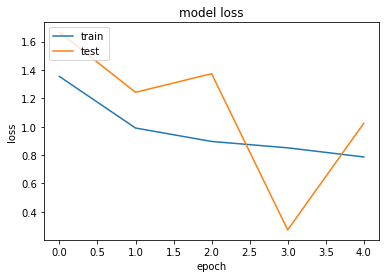

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()